# Bayesian Optimisation of starting Gaussian Process hyperparameters

In [1]:
from pathlib import Path
from shutil import copyfile
import pickle

Data manipulation

In [2]:
import numpy as np
import pandas as pd

Plotting / Visualisation

In [3]:
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 6)

Gaussian Process Regression

In [5]:
import gpflow
import tensorflow as tf

In [6]:
from tensorflow.python.client import device_lib
from gpflow.ci_utils import ci_niter
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14874211744067561757]

In [7]:
from gpflow.utilities import print_summary

In [8]:
gpflow.config.set_default_summary_fmt("notebook")

In [9]:
from tqdm.contrib.itertools import product

ModuleNotFoundError: No module named 'tqdm'

Input scaler:

In [10]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.exceptions import NotFittedError

In [11]:
from helpers import ScalerHelper

## Load previously exported data

In [12]:
dfs_train = []
dfs_test = []

In [13]:
train_exps = ['Exp1', 'Exp3', 'Exp5', 'Exp6']
test_exps = ['Exp2', 'Exp4', 'Exp7']

In [14]:
for exp in train_exps:
    dfs_train.append(pd.read_csv(f"../Data/Good_CARNOT/{exp}_table.csv").rename(columns = {'Power': 'SimulatedHeat'}))
    
for exp in test_exps:
    dfs_test.append(pd.read_csv(f"../Data/Good_CARNOT/{exp}_table.csv").rename(columns = {'Power': 'SimulatedHeat'}))

In [15]:
#t_cols = ['time_h', 'time_m']
t_cols = []
w_cols = ['SolRad', 'OutsideTemp']
u_cols = ['SimulatedHeat']
y_cols = ['SimulatedTemp']

In [44]:
t_lags = 0
w_lags = 1
u_lags = 1
y_lags = 3

In [45]:
dict_cols = {
    't': (t_lags, t_cols),
    'w': (w_lags, w_cols),
    'u': (u_lags, u_cols),
    'y': (y_lags, y_cols)
}

Create the scaler and set up input data scaling:

In [46]:
scaler = MinMaxScaler(feature_range = (-1, 1))

In [47]:
def get_scaled_df(df, dict_cols, scaler):
    
    t_list = dict_cols['t'][1]
    w_list = dict_cols['w'][1]
    u_list = dict_cols['u'][1]
    y_list = dict_cols['y'][1]
    
    df_local = df[t_list + w_list + u_list + y_list]
    df_scaled = df_local.to_numpy()
    
    try:
        df_scaled = scaler.transform(df_scaled)
    except NotFittedError:
        df_scaled = scaler.fit_transform(df_scaled)
        
    df_scaled = pd.DataFrame(df_scaled, index = df_local.index, columns = df_local.columns)
    
    return df_scaled

In [48]:
df_train = pd.concat(dfs_train)
df_train = df_train[t_cols + w_cols + u_cols + y_cols]
df_train.head()

,SolRad,OutsideTemp,SimulatedHeat,SimulatedTemp
0,57.936582,22.0,-31500,23.000000
1,54.914443,22.0,-31500,20.585367
2,73.944706,22.0,-31500,20.300922
3,76.206334,22.0,-31500,20.034647
4,65.120057,22.0,-31500,19.786064


Fit the scaler and scale the data:

In [49]:
df_train_sc = get_scaled_df(df_train, dict_cols, scaler)
#pickle.dump(scaler, open(Path("scaler.pkl"), 'wb'))

In [50]:
scaler_helper = ScalerHelper(scaler)

Scale the data for each experiment individually. Used for validation graphs and errors computation:

In [51]:
dfs_train_sc = []
dfs_test_sc = []
for df in dfs_train:
    df_sc = get_scaled_df(df, dict_cols, scaler)
    dfs_train_sc.append(df_sc)
    
for df in dfs_test:
    df_sc = get_scaled_df(df, dict_cols, scaler)
    dfs_test_sc.append(df_sc)

Set up the function which generated the GPR input matrix from the experimental data (including all autoregressive inputs, etc.):

In [52]:
def data_to_gpr(df, dict_cols):
    
    t_list = dict_cols['t'][1]
    w_list = dict_cols['w'][1]
    u_list = dict_cols['u'][1]
    y_list = dict_cols['y'][1]
    
    df_gpr = df[t_list + w_list + u_list + y_list].copy()
    
    for lags, names in dict_cols.values():
        for name in names:
            col_idx = df_gpr.columns.get_loc(name)
            for lag in range(1, lags + 1):
                df_gpr.insert(col_idx + lag, f"{name}_{lag}", df_gpr.loc[:, name].shift(lag))

    df_gpr.dropna(inplace = True)
    
    return df_gpr

In [53]:
dfs_gpr_train = []
for df_sc in dfs_train_sc:
    dfs_gpr_train.append(data_to_gpr(df_sc, dict_cols))
df_gpr_train = pd.concat(dfs_gpr_train)
df_gpr_train.head()

,SolRad,SolRad_1,OutsideTemp,OutsideTemp_1,SimulatedHeat,SimulatedHeat_1,SimulatedTemp,SimulatedTemp_1,SimulatedTemp_2,SimulatedTemp_3
3,-0.855164,-0.859463,0.058824,0.058824,-1.0,-1.0,-0.295224,-0.270561,-0.244215,-0.020567
4,-0.876235,-0.855164,0.058824,0.058824,-1.0,-1.0,-0.318248,-0.295224,-0.270561,-0.244215
5,-0.911207,-0.876235,0.058824,0.058824,-1.0,-1.0,-0.340062,-0.318248,-0.295224,-0.270561
6,-0.933425,-0.911207,0.058824,0.058824,1.0,-1.0,-0.361066,-0.340062,-0.318248,-0.295224
7,-0.952322,-0.933425,0.058824,0.058824,-1.0,1.0,0.051533,-0.361066,-0.340062,-0.318248


In [54]:
#df_gpr_train = df_gpr_train.sample(n = 500)

In [55]:
dfs_gpr_test = []
for df_sc in dfs_test_sc:
    dfs_gpr_test.append(data_to_gpr(df_sc, dict_cols))

In [56]:
df_input_train = df_gpr_train.drop(columns = dict_cols['w'][1] + dict_cols['u'][1] + dict_cols['y'][1])
df_output_train = df_gpr_train[dict_cols['y'][1]]

np_input_train = df_input_train.to_numpy()
np_output_train = df_output_train.to_numpy().reshape(-1, 1)

In [57]:
data_train = (np_input_train, np_output_train)
#pickle.dump(data_train, open(Path("data_train.pkl"), 'wb'))

In [58]:
df_input_train.head()

,SolRad_1,OutsideTemp_1,SimulatedHeat_1,SimulatedTemp_1,SimulatedTemp_2,SimulatedTemp_3
3,-0.859463,0.058824,-1.0,-0.270561,-0.244215,-0.020567
4,-0.855164,0.058824,-1.0,-0.295224,-0.270561,-0.244215
5,-0.876235,0.058824,-1.0,-0.318248,-0.295224,-0.270561
6,-0.911207,0.058824,-1.0,-0.340062,-0.318248,-0.295224
7,-0.933425,0.058824,1.0,-0.361066,-0.340062,-0.318248


In [59]:
## Define Kernel

In [60]:
nb_dims = np_input_train.shape[1]
rational_dims = np.arange(0, (dict_cols['t'][0] + 1) * len(dict_cols['t'][1]), 1)
nb_rational_dims = len(rational_dims)
squared_dims = np.arange(nb_rational_dims, nb_dims, 1)
nb_squared_dims = len(squared_dims)

In [61]:
print(f"rational: {nb_rational_dims}")
print(f"squared: {nb_squared_dims}")

rational: 0
squared: 6


In [62]:
squared_l = np.linspace(1, 1, nb_squared_dims)
rational_l = np.linspace(1, 1, nb_rational_dims)

In [63]:
variance = tf.math.reduce_variance(np_input_train)

In [72]:
k0 = gpflow.kernels.SquaredExponential(lengthscales = squared_l, active_dims = squared_dims, variance = variance)
k1 = gpflow.kernels.Constant(variance = variance)
k2 = gpflow.kernels.RationalQuadratic(lengthscales = rational_l, active_dims = rational_dims, variance = variance)
k3 = gpflow.kernels.Periodic(k2)
k4 = gpflow.kernels.Matern32(lengthscales = squared_l, active_dims = squared_dims, variance = variance)

In [73]:
k = (k0 + k1) * k2
k = k4
print_summary(k)

name,class,transform,prior,trainable,shape,dtype,value
Matern32.variance,Parameter,Softplus,,True,(),float64,0.37330157725061586
Matern32.lengthscales,Parameter,Softplus,,True,"(6,)",float64,"[1., 1., 1...."


## Compile Model

In [74]:
m = gpflow.models.GPR(
    data = data_train, 
    kernel = k, 
    mean_function = None,
    )
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.37330157725061586
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(6,)",float64,"[1., 1., 1...."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


In [75]:
#m.likelihood.variance.assign(0.5)

In [76]:
#gpflow.set_trainable(m.likelihood.variance, False)

## Train Model

In [77]:
opt = gpflow.optimizers.Scipy()

In [78]:
from datetime import datetime

In [79]:
start_time = datetime.now()
opt.minimize(m.training_loss, m.trainable_variables)
print(f"Finished fitting in {datetime.now() - start_time}")
print_summary(m)

Finished fitting in 0:08:52.197074


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,155314.92986790097
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(6,)",float64,"[40975.93283651, 181.65728243, 24643.70612896..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1e-06


Export model parameters:

In [80]:
pickle.dump(m, open(Path('gp_model.pkl'), 'wb'))
pickle.dump(dict_cols, open(Path('dict_cols.pkl'), 'wb'))

### Train SVGP model

In [48]:
N = data_train[0].shape[0]
M = 150 # Number of inducing locations
Z = data_train[0][:M, :].copy()

m = gpflow.models.SVGP(k, gpflow.likelihoods.Gaussian(), Z, num_data = N)

elbo = tf.function(m.elbo)

###
# Training
###

minibatch_size = 100
train_dataset = tf.data.Dataset.from_tensor_slices(data_train).repeat().shuffle(N)

# Turn off training for inducing point locations
gpflow.set_trainable(m.inducing_variable, False)

def run_adam(model, iterations):
    """
    Utility function running the Adam optimizer

    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    train_iter = iter(train_dataset.batch(minibatch_size))
    training_loss = model.training_loss_closure(train_iter, compile=True)
    optimizer = tf.optimizers.Adam()

    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)

    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
    return logf


maxiter = ci_niter(10000)
logf = run_adam(m, maxiter)

KeyboardInterrupt: 

## Evaluate performance on training data

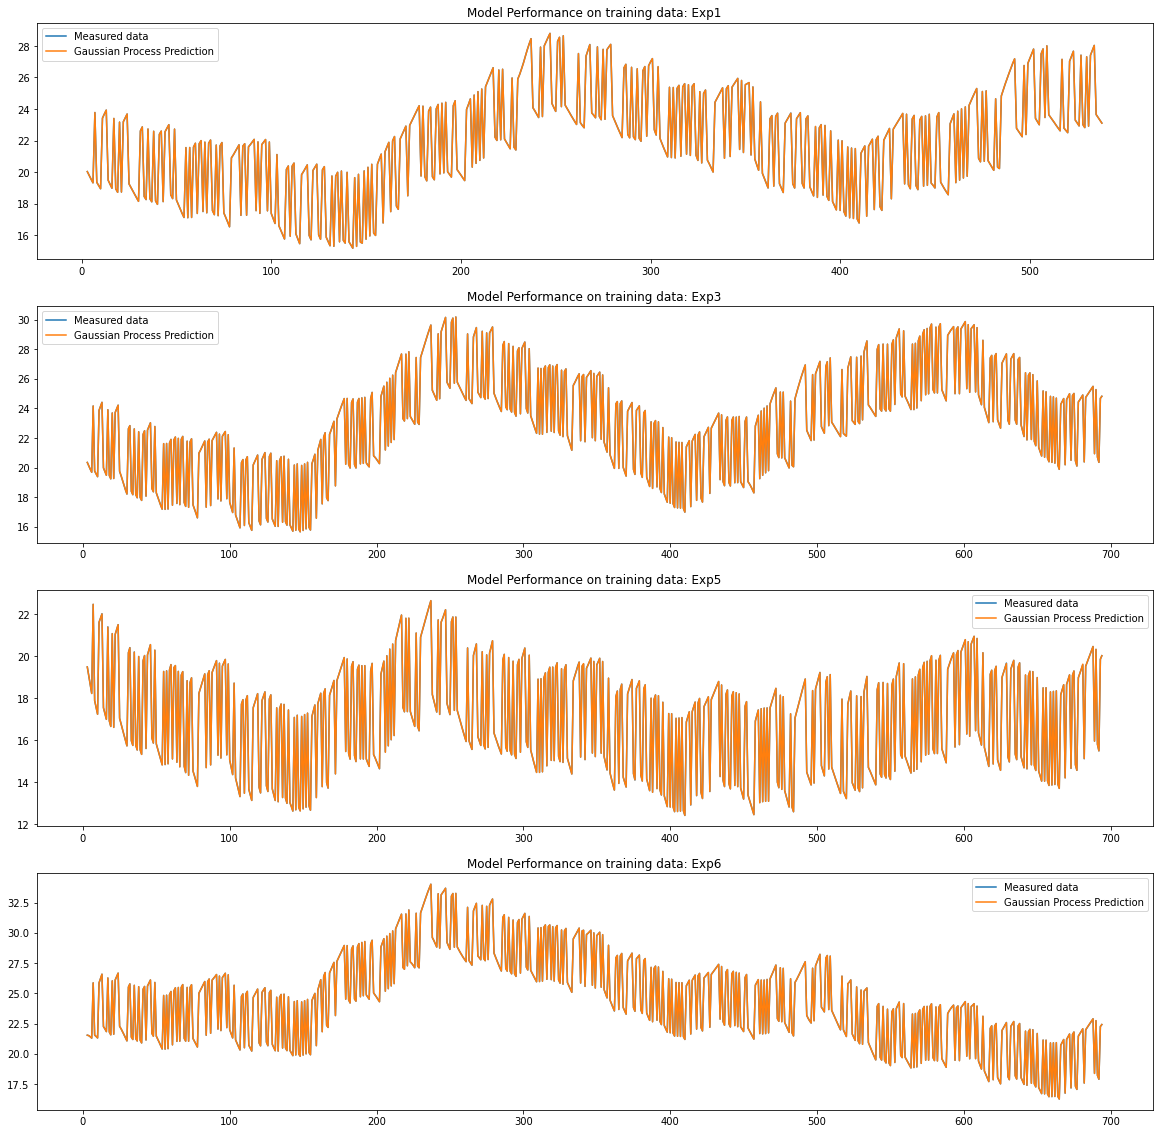

In [81]:
nb_plts = len(dfs_train)

fig, ax = plt.subplots(4, 1, figsize=(20, 20))

for idx, df_iter in enumerate(dfs_gpr_train):
    plt.subplot(4, 1, idx + 1)
    df_input_iter = df_iter.drop(columns = dict_cols['w'][1] + dict_cols['y'][1] + dict_cols['u'][1])
    df_output_iter = df_iter[dict_cols['y'][1]]
    np_input_iter = df_input_iter.to_numpy()
    np_output_iter = df_output_iter.to_numpy().reshape(-1, 1)
    
    mean, var = m.predict_f(np_input_iter)
    
    mean = scaler_helper.inverse_scale_output(mean).reshape((-1, 1))
    #var = scaler_helper.inverse_scale_output(var).reshape((-1, 1))
    scaled_measures = scaler_helper.inverse_scale_output(np_output_iter[:, :])
    
    plt.plot(df_iter.index, scaled_measures, label = 'Measured data')
    plt.plot(df_iter.index, mean, label = 'Gaussian Process Prediction')
    plt.fill_between(
        df_iter.index, 
        mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
        mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
        alpha = 0.2
    )
    plt.title(f"Model Performance on training data: {train_exps[idx]}")
    plt.legend()
plt.savefig(f"../Thesis/Plots/GP_training_performance.pdf", bbox_inches='tight')

## Evaluate performance on test data

In [82]:
def SMSE(measured, predicted):
    N = measured.size
    measured_var = np.var(measured)
    SMSE = np.power(measured - predicted, 2).sum()/(N*measured_var)
    return SMSE

In [83]:
def RMSE(measured, predicted):
    N = measured.size
    RMSE = np.sqrt(np.power(measured - predicted, 2).sum()/N)
    return RMSE

In [84]:
def LPD(measured, predicted_mean, predicted_var):
    N = measured.size
    sum_part = np.log(predicted_var) + np.power(measured - predicted_mean, 2)/predicted_var
    LPD = 1/2*np.log(2*np.pi) + 1/(2*N)*sum_part.sum()
    return LPD

In [85]:
def MSLL(measured, predicted_mean, predicted_var):
    measured_var = np.var(measured)
    measured_mean = np.mean(measured)
    return LPD(measured, predicted_mean, predicted_var) - LPD(measured, measured_mean, measured_var)

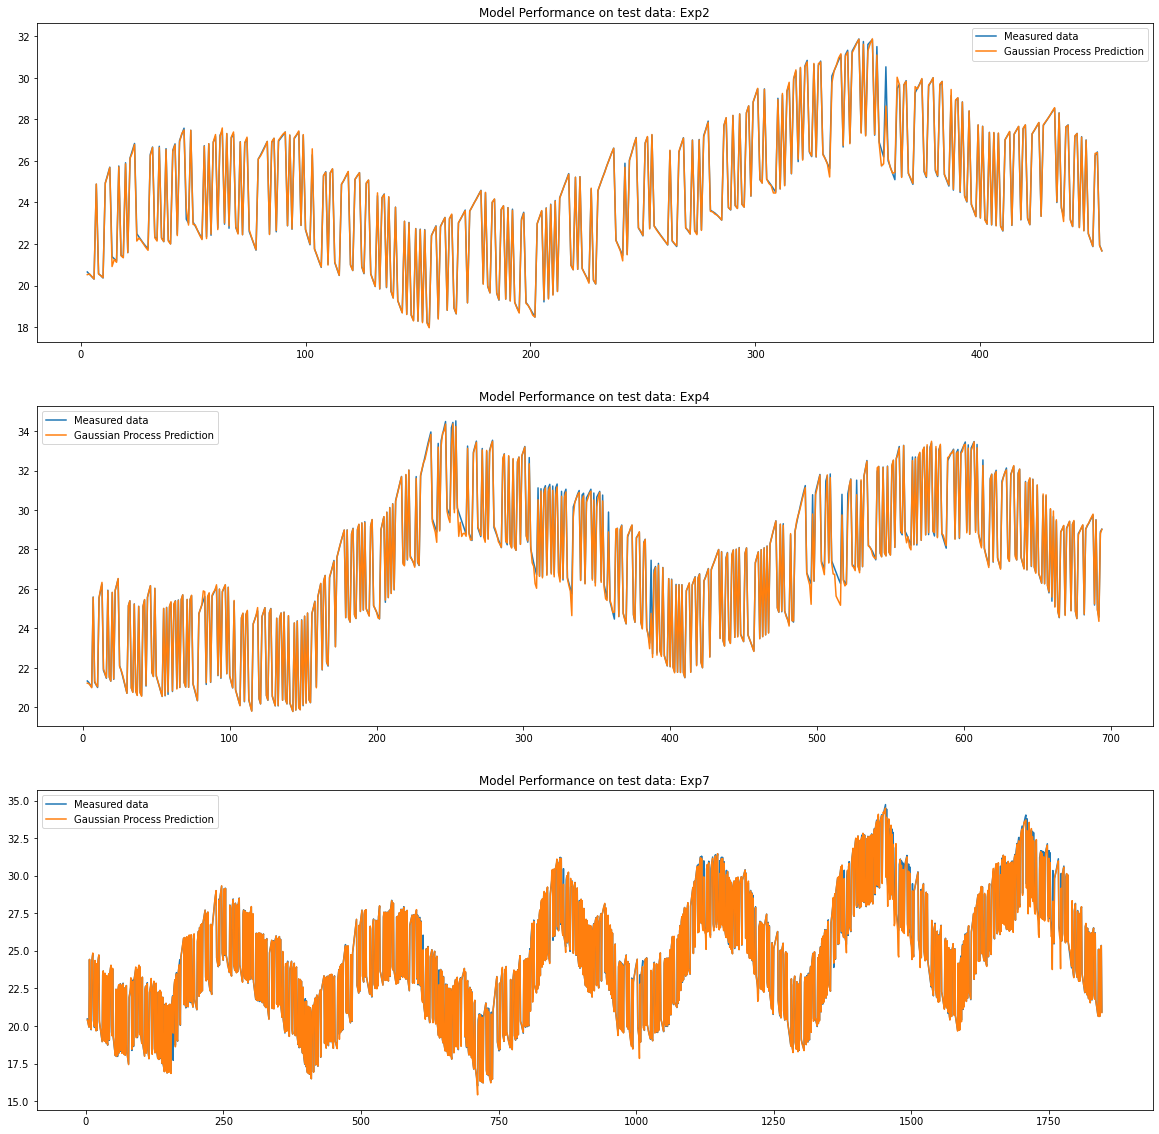

In [86]:
nb_plts = len(dfs_test)

test_smse = 0
test_rmse = 0
test_lpd = 0
test_msll = 0

plt.figure(figsize = (20, 20))

for idx, df_iter in enumerate(dfs_gpr_test):
    plt.subplot(nb_plts, 1, idx + 1)
    df_input_iter = df_iter.drop(columns = dict_cols['w'][1] + dict_cols['y'][1] + dict_cols['u'][1])
    df_output_iter = df_iter[dict_cols['y'][1]]
    np_input_iter = df_input_iter.to_numpy()
    np_output_iter = df_output_iter.to_numpy().reshape(-1, 1)
    
    mean, var = m.predict_f(np_input_iter)
    mean = mean.numpy()
    var = var.numpy()
    
    test_smse += SMSE(np_output_iter, mean)
    test_rmse += RMSE(np_output_iter, mean)
    test_lpd += LPD(np_output_iter, mean, var)
    test_msll += MSLL(np_output_iter, mean, var)
    
    
    mean = scaler_helper.inverse_scale_output(mean).reshape((-1, 1))
    #var = scaler_helper.inverse_scale_output(var).reshape((-1, 1))
    scaled_measures = scaler_helper.inverse_scale_output(np_output_iter[:, :])

    plt.plot(df_iter.index, scaled_measures, label = 'Measured data')
    plt.plot(df_iter.index, mean[:, :], label = 'Gaussian Process Prediction')
    plt.fill_between(
        df_iter.index, 
        mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
        mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
        alpha = 0.2
    )
    plt.title(f"Model Performance on test data: {test_exps[idx]}")
    plt.legend()
plt.savefig(f"Performance_test_exps.png")

In [87]:
print(f"--- Lags ---")
print(f"w_lags: {w_lags}, u_lags: {u_lags}, y_lags: {y_lags}")
print("--- Test errors ---")
print(f"RMSE: {test_rmse}, SMSE: {test_smse}, MSLL: {test_msll}, LPD: {test_lpd}")

--- Lags ---
w_lags: 1, u_lags: 1, y_lags: 3
--- Test errors ---
RMSE: 0.05070630392998371, SMSE: 0.007725763915918466, MSLL: -10.7159901541676, LPD: -9.762631896880064


## Generate a table of errors and lengthscales

In [52]:
#t_cols = ['time_h', 'time_m']
t_cols = []
w_cols = ['SolRad', 'OutsideTemp']
u_cols = ['SimulatedHeat']
y_cols = ['SimulatedTemp']

In [53]:
# Max lags, used to generate columns index
t_lags = 0
w_lags = 5
u_lags = 5
y_lags = 5

In [54]:
dict_cols = {
    't': (t_lags, t_cols),
    'w': (w_lags, w_cols),
    'u': (u_lags, u_cols),
    'y': (y_lags, y_cols)
}

In [55]:
lags_cols = ['w_lags', 'u_lags', 'y_lags']
err_cols = ['rmse', 'smse', 'msll', 'lpd'] + ['variance']
lscales_cols = data_to_gpr(df_sc, dict_cols).drop(columns = dict_cols['w'][1] + dict_cols['y'][1] + dict_cols['u'][1]).columns.to_list()

In [56]:
df_perf_cols = lags_cols + err_cols + lscales_cols

In [57]:
np_perf = np.empty((0, len(df_perf_cols)))

In [58]:
w_range = np.arange(1,6)
u_range = np.arange(1,6)
y_range = np.arange(1,6)

In [ ]:
np_perf = np.empty((0, len(df_perf_cols)))
for w_iter, u_iter, y_iter in product(w_range, u_range, y_range):
    
    # Define dict_cols
    dict_cols = {
        't': (t_lags, t_cols),
        'w': (w_iter, w_cols),
        'u': (u_iter, u_cols),
        'y': (y_iter, y_cols)
    }
    
    # Training data
    dfs_gpr_train = []
    for df_sc in dfs_train_sc:
        dfs_gpr_train.append(data_to_gpr(df_sc, dict_cols))
    df_gpr_train = pd.concat(dfs_gpr_train)
    
    dfs_gpr_test = []
    for df_sc in dfs_test_sc:
        dfs_gpr_test.append(data_to_gpr(df_sc, dict_cols))
        
    df_input_train = df_gpr_train.drop(columns = dict_cols['w'][1] + dict_cols['u'][1] + dict_cols['y'][1])
    df_output_train = df_gpr_train[dict_cols['y'][1]]

    np_input_train = df_input_train.to_numpy()
    np_output_train = df_output_train.to_numpy().reshape(-1, 1)

    data_train = (np_input_train, np_output_train)

    
    # Kernel
    nb_dims = np_input_train.shape[1]
    rational_dims = np.arange(0, (dict_cols['t'][0] + 1) * len(dict_cols['t'][1]), 1)
    nb_rational_dims = len(rational_dims)
    squared_dims = np.arange(nb_rational_dims, nb_dims, 1)
    nb_squared_dims = len(squared_dims)
    
    squared_l = np.linspace(1, 1, nb_squared_dims)
    rational_l = np.linspace(1, 1, nb_rational_dims)
    
    k0 = gpflow.kernels.SquaredExponential(lengthscales = squared_l, active_dims = squared_dims, variance = variance)
    
    k = k0
    
    nb_tries = 0
    train_success = False
    while True:
        try:
            if nb_tries > 2:
                break
            k0 = gpflow.kernels.SquaredExponential(lengthscales = squared_l, active_dims = squared_dims, variance = variance)
            k = k0

            # Model definition and training
            m = gpflow.models.GPR(
            data = data_train, 
            kernel = k, 
            mean_function = None,
            )

            opt = gpflow.optimizers.Scipy()
            opt.minimize(m.training_loss, m.trainable_variables)
            train_success = True
            break
        except:
            nb_tries += 1
        
    if not train_success:
        continue
    
    nb_plts = len(dfs_test)

    test_smse = 0
    test_rmse = 0
    test_lpd = 0
    test_msll = 0

    for idx, df_iter in enumerate(dfs_gpr_test):
        df_input_iter = df_iter.drop(columns = dict_cols['w'][1] + dict_cols['y'][1] + dict_cols['u'][1])
        df_output_iter = df_iter[dict_cols['y'][1]]
        np_input_iter = df_input_iter.to_numpy()
        np_output_iter = df_output_iter.to_numpy().reshape(-1, 1)

        mean, var = m.predict_f(np_input_iter)

        test_smse += SMSE(np_output_iter, mean.numpy())
        test_rmse += RMSE(np_output_iter, mean.numpy())
        test_lpd += LPD(np_output_iter, mean.numpy(), var.numpy())
        test_msll += MSLL(np_output_iter, mean.numpy(), var.numpy())
        
    # Compute the current row in df_perf
    
    iter_lagcols = df_input_train.columns.tolist()
    
    np_perf_iter = np.nan * np.ones((1, len(df_perf_cols)))
    np_perf_iter[0,0] = w_iter
    np_perf_iter[0,1] = u_iter
    np_perf_iter[0,2] = y_iter
    np_perf_iter[0,3] = test_rmse
    np_perf_iter[0,4] = test_smse
    np_perf_iter[0,5] = test_msll
    np_perf_iter[0,6] = test_lpd
    np_perf_iter[0,7] = gpflow.utilities.parameter_dict(m)['.kernel.variance'].numpy()
    
    for iter_lag in iter_lagcols:
        iter_lag_idx = df_input_train.columns.to_list().index(iter_lag)
        perf_lag_idx = df_perf_cols.index(iter_lag)
        np_perf_iter[0,perf_lag_idx] = gpflow.utilities.parameter_dict(m)['.kernel.lengthscales'].numpy()[iter_lag_idx]
        

    np_perf = np.vstack([np_perf, np_perf_iter])
    
    # Save the output for this iteration
    df_perf_iter = pd.DataFrame(np_perf, columns = df_perf_cols).to_csv(f"df_perf_GP_{w_iter}w_{u_iter}u_{y_iter}y.csv")

  0%|          | 0/125 [00:00<?, ?it/s]

In [ ]:
np_perf = np.empty((0, len(df_perf_cols)))
for w_iter, u_iter, y_iter in product(w_range, u_range, y_range):

    # Define dict_cols
    dict_cols = {
        't': (t_lags, t_cols),
        'w': (w_iter, w_cols),
        'u': (u_iter, u_cols),
        'y': (y_iter, y_cols)
    }

    # Training data
    dfs_gpr_train = []
    for df_sc in dfs_train_sc:
        dfs_gpr_train.append(data_to_gpr(df_sc, dict_cols))
    df_gpr_train = pd.concat(dfs_gpr_train)

    dfs_gpr_test = []
    for df_sc in dfs_test_sc:
        dfs_gpr_test.append(data_to_gpr(df_sc, dict_cols))

    df_input_train = df_gpr_train.drop(columns = dict_cols['w'][1] + dict_cols['u'][1] + dict_cols['y'][1])
    df_output_train = df_gpr_train[dict_cols['y'][1]]

    np_input_train = df_input_train.to_numpy()
    np_output_train = df_output_train.to_numpy().reshape(-1, 1)

    data_train = (np_input_train, np_output_train)


    # Kernel
    nb_dims = np_input_train.shape[1]
    rational_dims = np.arange(0, (dict_cols['t'][0] + 1) * len(dict_cols['t'][1]), 1)
    nb_rational_dims = len(rational_dims)
    squared_dims = np.arange(nb_rational_dims, nb_dims, 1)
    nb_squared_dims = len(squared_dims)

    squared_l = np.linspace(1, 1, nb_squared_dims)
    rational_l = np.linspace(1, 1, nb_rational_dims)

    nb_tries = 0
    train_success = False
    while True:
        try:
            if nb_tries > 2:
                break
            k0 = gpflow.kernels.SquaredExponential(lengthscales = squared_l, active_dims = squared_dims, variance = variance)
            k = k0     

            N = data_train[0].shape[0]
            M = 150 # Number of inducing locations
            Z = data_train[0][:M, :].copy()

            m = gpflow.models.SVGP(k, gpflow.likelihoods.Gaussian(), Z, num_data = N)

            elbo = tf.function(m.elbo)

            ###
            # Training
            ###

            minibatch_size = 100
            train_dataset = tf.data.Dataset.from_tensor_slices(data_train).repeat().shuffle(N)

            # Turn off training for inducing point locations
            gpflow.set_trainable(m.inducing_variable, False)

            def run_adam(model, iterations):
                """
                Utility function running the Adam optimizer

                :param model: GPflow model
                :param interations: number of iterations
                """
                # Create an Adam Optimizer action
                logf = []
                train_iter = iter(train_dataset.batch(minibatch_size))
                training_loss = model.training_loss_closure(train_iter, compile=True)
                optimizer = tf.optimizers.Adam()

                @tf.function
                def optimization_step():
                    optimizer.minimize(training_loss, model.trainable_variables)

                for step in range(iterations):
                    optimization_step()
                    if step % 10 == 0:
                        elbo = -training_loss().numpy()
                        logf.append(elbo)
                return logf


            maxiter = ci_niter(10000)
            logf = run_adam(m, maxiter)

            train_success = True
            break
        except:
            nb_tries += 1

    if not train_success:
        continue

    nb_plts = len(dfs_test)

    test_smse = 0
    test_rmse = 0
    test_lpd = 0
    test_msll = 0

    for idx, df_iter in enumerate(dfs_gpr_test):
        df_input_iter = df_iter.drop(columns = dict_cols['w'][1] + dict_cols['y'][1] + dict_cols['u'][1])
        df_output_iter = df_iter[dict_cols['y'][1]]
        np_input_iter = df_input_iter.to_numpy()
        np_output_iter = df_output_iter.to_numpy().reshape(-1, 1)

        mean, var = m.predict_f(np_input_iter)

        test_smse += SMSE(np_output_iter, mean.numpy())
        test_rmse += RMSE(np_output_iter, mean.numpy())
        test_lpd += LPD(np_output_iter, mean.numpy(), var.numpy())
        test_msll += MSLL(np_output_iter, mean.numpy(), var.numpy())

    # Compute the current row in df_perf

    iter_lagcols = df_input_train.columns.tolist()

    np_perf_iter = np.nan * np.ones((1, len(df_perf_cols)))
    np_perf_iter[0,0] = w_iter
    np_perf_iter[0,1] = u_iter
    np_perf_iter[0,2] = y_iter
    np_perf_iter[0,3] = test_rmse
    np_perf_iter[0,4] = test_smse
    np_perf_iter[0,5] = test_msll
    np_perf_iter[0,6] = test_lpd
    np_perf_iter[0,7] = gpflow.utilities.parameter_dict(m)['.kernel.variance'].numpy()

    for iter_lag in iter_lagcols:
        iter_lag_idx = df_input_train.columns.to_list().index(iter_lag)
        perf_lag_idx = df_perf_cols.index(iter_lag)
        np_perf_iter[0,perf_lag_idx] = gpflow.utilities.parameter_dict(m)['.kernel.lengthscales'].numpy()[iter_lag_idx]


    np_perf = np.vstack([np_perf, np_perf_iter])

    # Save the output for this iteration
    df_perf_iter = pd.DataFrame(np_perf, columns = df_perf_cols).to_csv(f"df_perf_SVGP_{w_iter}w_{u_iter}u_{y_iter}y.csv")

In [ ]:
gpflow.utilities.parameter_dict(m)['.kernel.lengthscales'].numpy()

## Multistep prediction

In [88]:
df_input = dfs_gpr_test[1].drop(columns = dict_cols['w'][1] + dict_cols['u'][1] + dict_cols['y'][1])
df_output = dfs_gpr_test[1][dict_cols['y'][1]]

In [89]:
start_idx = 25
nb_predictions = 25
N_pred = 20

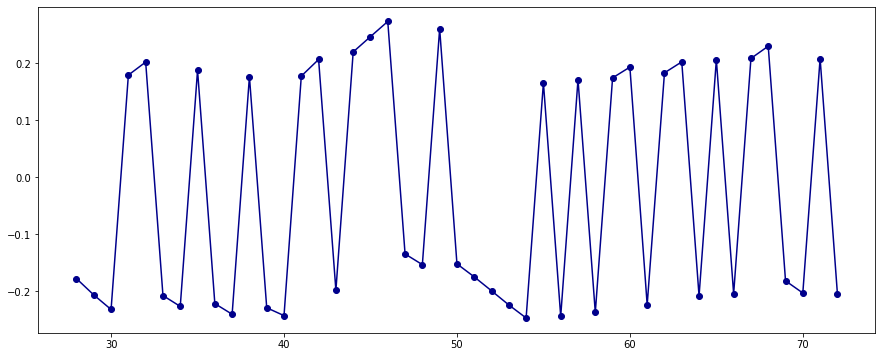

In [90]:
plt.figure()
plt.plot(df_output.iloc[start_idx:start_idx + nb_predictions + N_pred], 'o-', label = 'measured', color = 'darkblue')

In [91]:
df_iter

,SolRad,SolRad_1,OutsideTemp,OutsideTemp_1,SimulatedHeat,SimulatedHeat_1,SimulatedTemp,SimulatedTemp_1,SimulatedTemp_2,SimulatedTemp_3
3,-0.828499,-0.686753,0.294118,0.294118,-1.0,-1.0,-0.255370,-0.240796,-0.227086,-0.020567
4,-0.858285,-0.828499,0.294118,0.294118,-1.0,-1.0,-0.270921,-0.255370,-0.240796,-0.227086
5,-0.866567,-0.858285,0.294118,0.294118,-1.0,-1.0,-0.287999,-0.270921,-0.255370,-0.240796
6,-0.864584,-0.866567,0.294118,0.294118,1.0,-1.0,-0.305151,-0.287999,-0.270921,-0.255370
7,-0.811292,-0.864584,0.294118,0.294118,-1.0,1.0,0.111516,-0.305151,-0.287999,-0.270921
...,...,...,...,...,...,...,...,...,...,...
1842,-0.993804,-0.994013,0.058824,0.058824,-1.0,1.0,0.174022,-0.238089,0.173677,-0.236739
1843,-0.993823,-0.993804,0.058824,0.058824,1.0,-1.0,-0.236873,0.174022,-0.238089,0.173677
1844,-0.993842,-0.993823,0.058824,0.058824,1.0,1.0,0.175584,-0.236873,0.174022,-0.238089
1845,-0.993652,-0.993842,0.058824,0.058824,-1.0,1.0,0.197791,0.175584,-0.236873,0.174022


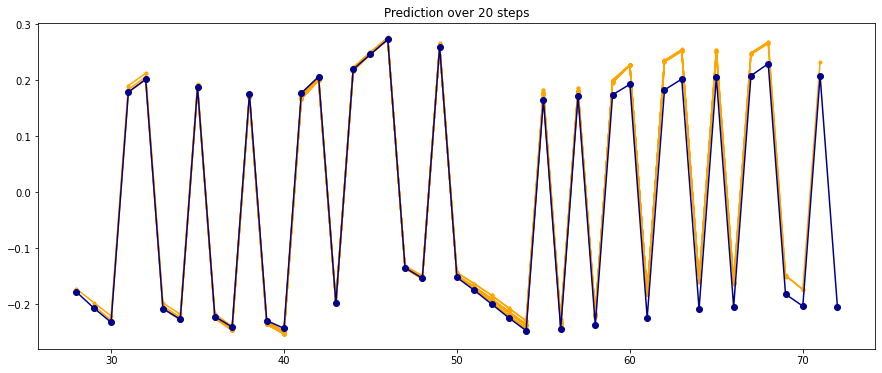

In [92]:
plt.figure()

y_name = dict_cols['y'][1][0]
for idx in range(start_idx, start_idx + nb_predictions):
    df_iter = df_input.iloc[idx:(idx + N_pred)].copy()
    for idxx in range(N_pred - 1):
        idx_old = df_iter.index[idxx]
        idx_new = df_iter.index[idxx+1]
        mean, var = m.predict_f(df_iter.loc[idx_old, :].to_numpy().reshape(1, -1))
        df_iter.loc[idx_new, f'{y_name}_1'] = mean.numpy().flatten()
        for lag in range(2, dict_cols['y'][0] + 1):
            df_iter.loc[idx_new, f"{y_name}_{lag}"] = df_iter.loc[idx_old, f"{y_name}_{lag-1}"]
        
    mean_iter, var_iter = m.predict_f(df_iter.to_numpy())
    plt.plot(df_iter.index, mean_iter.numpy(), '.-', label = 'predicted', color = 'orange')
plt.plot(df_output.iloc[start_idx:start_idx + nb_predictions + N_pred], 'o-', label = 'measured', color = 'darkblue')
plt.title(f"Prediction over {N_pred} steps")
plt.savefig(f"prediction_{N_pred}_steps.png")

## Test CasADi problem

In [ ]:
import casadi as cs

In [ ]:
class GPR(cs.Callback):
    def __init__(self, name, model, opts={}):
        cs.Callback.__init__(self)

        self.model = model
        self.n_in = model.data[0].shape[1]
        # Create a variable to keep all the gradient callback references
        self.refs = []

        self.construct(name, opts)
    
    # Number of inputs/outputs
    def get_n_in(self): return 1
    def get_n_out(self): return 1
    

    # Sparsity of the input/output
    def get_sparsity_in(self,i):
        return cs.Sparsity.dense(1,self.n_in)
    def get_sparsity_out(self,i):
        return cs.Sparsity.dense(1,1)


    def eval(self, arg):
        inp = np.array(arg[0])
        inp = tf.Variable(inp, dtype=tf.float64)
        [mean, _] = self.model.predict_f(inp)
        return [mean.numpy()]
    
    def has_reverse(self, nadj): return nadj==1
    def get_reverse(self, nadj, name, inames, onames, opts):
        grad_callback = GPR_grad(name, self.model)
        self.refs.append(grad_callback)
        
        nominal_in = self.mx_in()
        nominal_out = self.mx_out()
        adj_seed = self.mx_out()
        return cs.Function(name, nominal_in+nominal_out+adj_seed, grad_callback.call(nominal_in), inames, onames)
        
class GPR_grad(cs.Callback):
    def __init__(self, name, model, opts={}):
        cs.Callback.__init__(self)  
        self.model = model
        self.n_in = model.data[0].shape[1]

        self.construct(name, opts)

    
    def get_n_in(self): return 1
    def get_n_out(self): return 1
    
    def get_sparsity_in(self,i):
        return cs.Sparsity.dense(1,self.n_in)
    def get_sparsity_out(self,i):
        return cs.Sparsity.dense(1,self.n_in)


    def eval(self, arg):
        inp = np.array(arg[0])
        inp = tf.Variable(inp, dtype=tf.float64)
        
        with tf.GradientTape() as tape:
            preds = self.model.predict_f(inp)

        grads = tape.gradient(preds, inp)
        return [grads.numpy()]

In [ ]:
cs_model = GPR("gpr", m)

In [ ]:
N_horizon = 5;

T_set = 23;
T_set_sc = scaler.transform(np.array([0, 0, 0, T_set]).reshape(1, -1))[0, 3]
n_states = m.data[0].shape[1]

In [ ]:
total_cols = 0
for lags, cols in dict_cols.values():
    total_cols += lags*(len(cols)+1)
total_cols = total_cols -2
print(total_cols)

In [ ]:
W = cs.MX.sym("W", N_horizon, 2)
U = cs.MX.sym("U", N_horizon, 1)
x0 = cs.MX.sym("x0", 1, n_states)
Xk = cs.MX.sym("Xk", 0, n_states)

In [ ]:
yhats = cs.MX.sym("yhats", 0, 1)

In [ ]:
yhat = cs_model(x0)

In [ ]:
yhats = cs.vertcat(yhats, yhat)

### First step

In [ ]:
xk = x0

### All the other steps

In [ ]:
for row_idx in range(N_horizon):
    # w
    base_idx = 0
    nb_cols = len(dict_cols['w'][1])*(dict_cols['w'][0])
    wk_1 = xk[base_idx:base_idx + nb_cols]
    
    wk = cs.MX.sym("wk", 1, 0)
    nb_lags = dict_cols['w'][0]

    for idx in range(W.shape[1]):
        base_col = idx * (nb_lags - 1)
        wk = cs.horzcat(wk, W[row_idx, idx], wk_1[base_col:base_col + nb_lags - 1])
        
    # u
    base_idx += nb_cols
    nb_cols = len(dict_cols['u'][1])*dict_cols['u'][0]
    uk_1 = xk[base_idx:base_idx + nb_cols]

    
    nb_lags = dict_cols['u'][0] - 1
    uk = cs.horzcat(U[row_idx], uk_1[:nb_lags])
    
    # y
    base_idx += nb_cols
    nb_cols = len(dict_cols['y'][1])*dict_cols['y'][0]
    yk_1 = xk[base_idx: base_idx + nb_cols]
    
    nb_lags = dict_cols['y'][0] - 1
    yk = cs.horzcat(yhat, yk_1[:nb_lags])
    
    xk = cs.horzcat(wk, uk, yk)
    Xk = cs.vertcat(Xk, xk)
    yhat = cs_model(xk)
    yhats = cs.vertcat(yhats, yhat)


Helper functions to easily reproduce everything:

In [ ]:
ff = cs.Function('ff', [W, U, x0], [yhats])

In [ ]:
Ff = cs.Function('Ff', [W, U, x0], [Xk])

Compute the objective function:

In [ ]:
y_diff = yhats - T_set_sc
J = cs.dot(y_diff, y_diff)

Compute the parameters vector:

In [ ]:
p = cs.vertcat(cs.vec(W), cs.vec(x0))

In [ ]:
prob = {"x": cs.vec(U), "f": J, "p": p}
options = {"ipopt": {"hessian_approximation": "limited-memory", "max_cpu_time": 500,
                    "acceptable_tol": 1e-8, "acceptable_obj_change_tol": 1e-6}}

In [ ]:
solver = cs.nlpsol("solver","ipopt",prob, options)

Check the functions on "real" values

In [ ]:
real_W = np.random.rand(*W.shape)
real_U = np.random.rand(*U.shape).reshape(-1, 1)
real_x0 = np.random.rand(*x0.shape).reshape(1, -1)

In [ ]:
yhats_ff = ff(real_W, real_U, real_x0)
np.array(yhats_ff)

In [ ]:
Xk_Ff = Ff(real_W, real_U, real_x0)
pd.DataFrame(np.array(Xk_Ff), columns = df_input_train.columns)

In [ ]:
np_realxk = np.empty((N_horizon + 1, n_states))
np_realxk[0, :] =  real_x0
np_realxk[1:, :2] =  real_W
np_realxk[1:, 2] =  real_U.ravel()

for row_idx in range(N_horizon):
    mean, _ = m.predict_f(np_realxk[row_idx, :].reshape(1, -1))
    np_realxk[row_idx + 1, 3] = np_realxk[row_idx, 2]
    np_realxk[row_idx + 1, 4] = mean
    np_realxk[row_idx + 1, 5] = np_realxk[row_idx, 4]
    np_realxk[row_idx + 1, 6] = np_realxk[row_idx, 5]
np_yhats, _ = m.predict_f(np_realxk)
np_yhats

In [ ]:
yhats_ff - np_yhats

In [ ]:
mean, _ = m.predict_f(np_realxk[2,:].reshape(1, -1))
mean

### Set up the problem and solve it

In [ ]:
start_idx = 25
test_gpr = data_to_gpr(dfs_test_sc[0], dict_cols).drop(columns = u_cols + y_cols)
real_x0 = cs.DM(test_gpr.iloc[start_idx, :].to_numpy())
real_W0 = cs.DM(test_gpr.iloc[start_idx + 1: start_idx + N_horizon, :2].to_numpy())

In [ ]:
real_p = cs.vertcat(cs.vec(real_W0), cs.vec(real_x0))

In [ ]:
test_gpr.iloc[start_idx: start_idx + N_horizon + 1]

In [ ]:
res = solver(lbx = -1, ubx = 1, p = real_p, x0 = -1)

In [ ]:
res['x']

In [ ]:
Ff(real_W, np.ones((N_horizon, 1)), real_x0)

In [ ]:
Ff(real_W, res['x'], real_x0)

In [ ]:
cs.norm_2(ff(real_W, np.ones((N_horizon, 1)), real_x0) - T_set_sc)

In [ ]:
cs.norm_2(ff(real_W, res['x'], real_x0) - T_set_sc)

In [ ]:
T_set

### Multiple shooting problem formulation

In [ ]:
N_horizon = 15

In [ ]:
X = cs.MX.sym("X", N_horizon + 1, n_states)
lbd = cs.MX.sym("lambda")
x0 = cs.MX.sym("x0", 1, n_states)
W = cs.MX.sym("W", N_horizon, 2)

In [ ]:
g = []
lbg = []
ubg = []

lbx = -np.inf*np.ones(X.shape)
ubx = np.inf*np.ones(X.shape)

T_set_sc = 2.5
##
# Set up the opjective function
##

# stage cost
u_cost = cs.dot(X[:, 2], X[:, 2])

# temperature constraint
y_cost = 0.01 * cs.dot(X[:, 4], X[:, 4])

J = u_cost + y_cost

In [ ]:
# Set up equality constraints for the first step
for idx in range(n_states):
    g.append(X[0, idx] - x0[0, idx])
    lbg.append(0)
    ubg.append(0)

In [ ]:
# Set up equality constraints for the following steps
for idx in range(1, N_horizon + 1):
    base_col = 0
    # w
    nb_cols = dict_cols['w'][0]
    for w_idx in range(W.shape[1]):
        w_base_col = w_idx * nb_cols
        g.append(X[idx, base_col + w_base_col] - W[idx - 1, w_idx])
        lbg.append(0)
        ubg.append(0)
        for w_lag_idx in range(1, nb_cols):
            g.append(X[idx, base_col + w_base_col + w_lag_idx] - X[idx - 1, base_col + w_base_col + w_lag_idx - 1])
            lbg.append(0)
            ubg.append(0)
            
    base_col += nb_cols * W.shape[1]
    # u
    nb_cols = dict_cols['u'][0]

    lbx[idx, base_col] = -1 #lower bound on input
    ubx[idx, base_col] = 1 #upper bound on input
    for u_lag_idx in range(1, nb_cols):
        g.append(X[idx, base_col + u_lag_idx] - X[idx - 1, base_col + u_lag_idx - 1])
        lbg.append(0)
        ubg.append(0)
    
    base_col += nb_cols
    # y
    nb_cols = dict_cols['y'][0]
    g.append(X[idx, base_col] - cs_model(X[idx - 1, :]))
    lbg.append(0)
    ubg.append(0)
    for y_lag_idx in range(1, nb_cols):
        g.append(X[idx, base_col + y_lag_idx] - X[idx - 1, base_col + y_lag_idx - 1])
        lbg.append(0)
        ubg.append(0)

In [ ]:
p = cs.vertcat(cs.vec(W), cs.vec(x0))

In [ ]:
prob = {'f': J, 'x': cs.vec(X), 'g': cs.vertcat(*g), 'p': p}
options = {"ipopt": {"hessian_approximation": "limited-memory", "max_iter": 100,
                     #"acceptable_tol": 1e-6, "tol": 1e-6,
                     "linear_solver": "ma97",
                     #"acceptable_obj_change_tol": 1e-5, 
                     #"mu_strategy": "adaptive",
                    }}
solver = cs.nlpsol("solver","ipopt",prob, options)

In [ ]:
real_x0 = np.random.rand(*x0.shape)
real_x0

In [ ]:
real_W = np.random.rand(*W.shape)
real_W

In [ ]:
real_p = cs.vertcat(cs.vec(real_W), cs.vec(real_x0))

In [ ]:
res = solver(lbx = cs.vec(lbx), ubx = cs.vec(ubx), p = real_p, lbg = lbg, ubg = ubg)

In [ ]:
np_res = np.array(res['x'].reshape(X.shape))
pd.DataFrame(np_res, columns = df_input.columns)

In [ ]:
mean, var = m.predict_f(np_res)

In [ ]:
mean